In [ ]:
import sys
import os
import json
import numpy as np
import pandas as pd
from importlib import import_module
import matplotlib.pyplot as plt
from types import MethodType

# Add the parent directory to the Python path
sys.path.append(os.path.abspath('..')) # if this script is in a subdirectory

# Load TVAE modules
from tvae.tvae_wrapper import TVAESynthesizer, LossValuesMixin
from tvae.data_loader import load_csvs

# Load SDV modules
from sdv.metadata import Metadata, SingleTableMetadata
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality

In [30]:
datasets = load_csvs(folder_name='/home/mfacotti/martin/tVAE_Synthesis/data')

# load data
rhc_data = datasets['rhc']

# Display basic information about the loaded data
print(f"Dataset shape: {rhc_data.shape}")

Dataset shape: (5735, 62)


/home/mfacotti/martin/tVAE_Synthesis/tvae/data_loader.py:36: UserWarning: Ignoring incompatible files ['metadata.json'] in folder '/home/mfacotti/martin/tVAE_Synthesis/data'.
  warnings.warn(f"Ignoring incompatible files {other_files} in folder '{folder_name}'.")


In [31]:
metadata = SingleTableMetadata()
metadata = Metadata.load_from_json('/home/mfacotti/martin/tVAE_Synthesis/data/metadata.json')
metadata.validate()

In [53]:
model = TVAESynthesizer(
        metadata,
        embedding_dim=32, # latent space dimensions
        compress_dims=(128, 32), # encoder dimensions
        decompress_dims=(32, 128), # decoder dimensions
        l2scale=1e-5,
        batch_size=256,
        verbose=True,
        epochs=500,
        loss_factor=2,
)

model.fit(rhc_data)

Loss: 48.407: 100%|██████████| 500/500 [12:41<00:00,  1.52s/it]


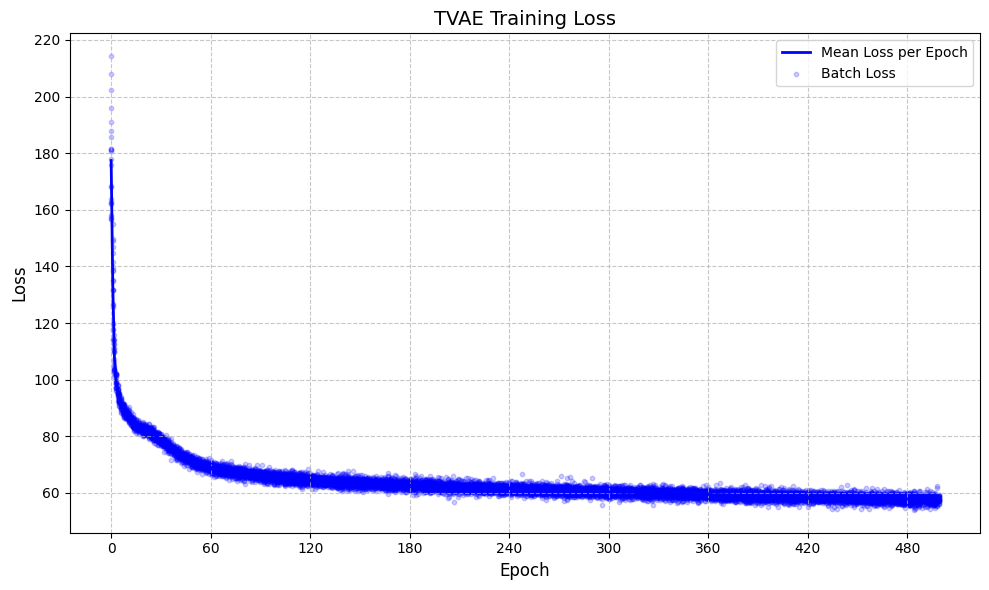

In [49]:
model.plot_loss(show_batch_loss=True);  # Note the semicolon

In [ ]:
model_name = 'tvae3_ep500_compress32'
model_filepath = f'test_model_{model_name}.pkl'

In [ ]:
model.save(
    filepath=model_filepath
)

In [50]:
synthetic_data = model.sample(num_rows=5000,)

In [ ]:
output_filename = f'synthetic_data_{model_name}.csv'
synthetic_data.to_csv(output_filename, index=False)

In [51]:
diagnostic = run_diagnostic(
    real_data=rhc_data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 62/62 [00:00<00:00, 587.83it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 227.95it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [52]:
quality_report = evaluate_quality(
    rhc_data,
    synthetic_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 62/62 [00:03<00:00, 18.15it/s]|
Column Shapes Score: 87.07%

(2/2) Evaluating Column Pair Trends: |██████████| 1891/1891 [00:18<00:00, 103.87it/s]|
Column Pair Trends Score: 77.98%

Overall Score (Average): 82.52%



Missing Values Percentage Comparison:
         Real Data (%)  Synthetic Data (%)
cat2         79.075850               89.58
adld3p       74.908457               78.06
urin1        52.798605               52.76
dthdte       35.100262               34.16
dschdte       0.017437                0.02


<Figure size 1400x800 with 0 Axes>

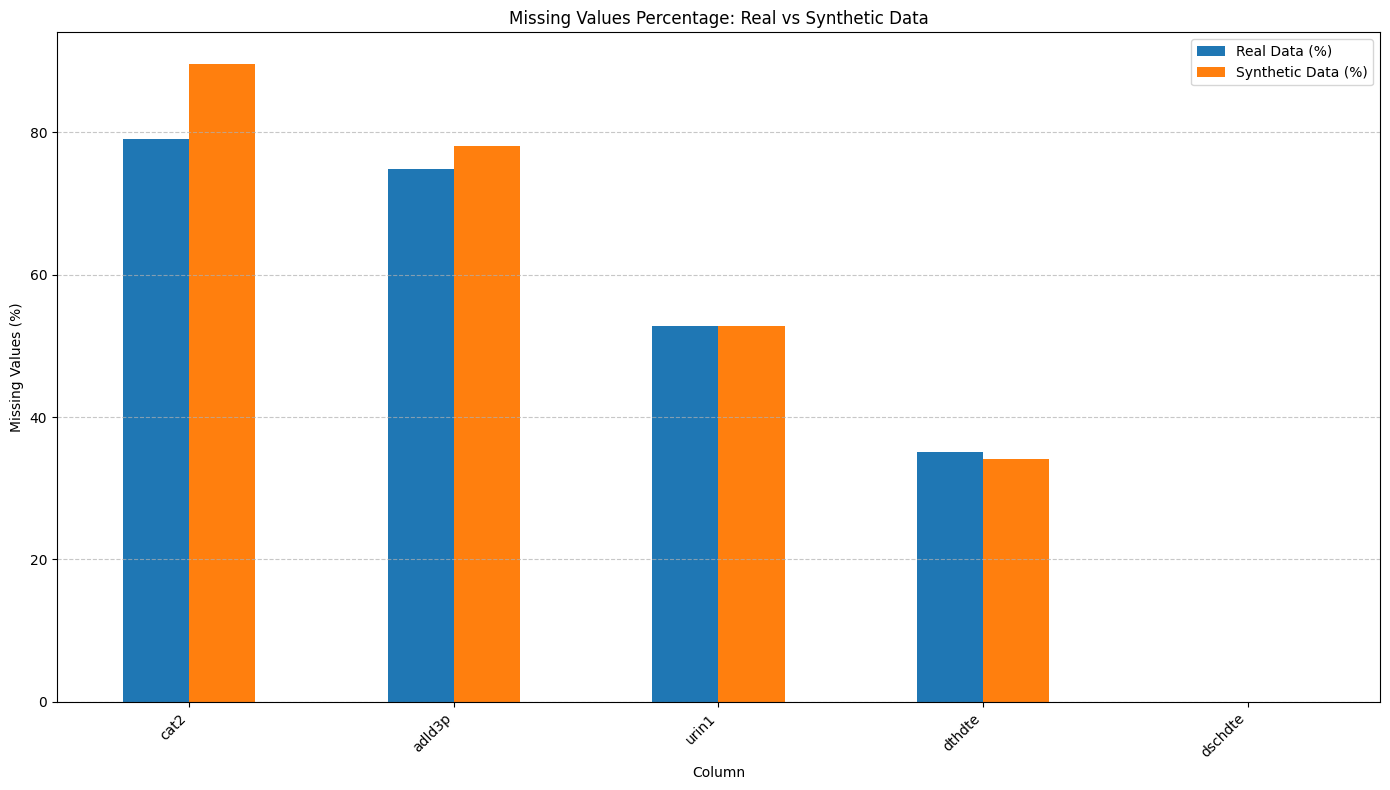

In [47]:
# Compare missing values percentage between real and synthetic data
missing_real = rhc_data.isna().mean().sort_values(ascending=False) * 100
missing_synthetic = synthetic_data.isna().mean().sort_values(ascending=False) * 100

# Filter only columns with missing values
missing_comparison = pd.DataFrame({
    'Real Data (%)': missing_real[missing_real > 0],
    'Synthetic Data (%)': missing_synthetic.reindex(missing_real[missing_real > 0].index)
})

# Display comparison
print("Missing Values Percentage Comparison:")
print(missing_comparison)

# Visualize the comparison
plt.figure(figsize=(14, 8))
missing_comparison.plot(kind='bar', figsize=(14, 8))
plt.title('Missing Values Percentage: Real vs Synthetic Data')
plt.ylabel('Missing Values (%)')
plt.xlabel('Column')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()